# **Test de imagen y vídeo**

Estas celdas pone a prueba el *core* y algunos bloques de la librería.

Funciona en la versión 0.1.19, pero más allá puede que no.

Los submódulos **core** y **blocks** aún no están *congelados*.

---

**ATENCIÓN**: Las celdas con vídeo son (muy) lentas si las usas en Colab. Incluso con un kernel con GPU. Usa un servidor jupyter local.

## **TODO**

* Modificar los signals/slots, de [ ] a ( )
* VideoSink
* ImageSink



In [ ]:
# https://mediapipe-studio.webapps.google.com/home

#!pip -q install ml4teens==0.1.20

In [1]:
import warnings;

warnings.filterwarnings('ignore');

In [2]:
import PIL;
import numpy as np;

from PIL.Image import Image;

# https://github.com/ageitgey/face_recognition

import face_recognition as fr;

from ml4teens.core import Block;

class FaceDetection(Block):

      #-------------------------------------------------------------------------
      def __init__(self, **kwargs):
          super().__init__();

      #-------------------------------------------------------------------------
      # SLOTS
      #-------------------------------------------------------------------------
      @Block.slot("image", {Image})
      def slot_image(self, slot, data):
          array=np.array(data.convert("RGB"));
          salida=data.copy();
          if self.signal_boxes():
             locations = fr.face_locations(array);
             imageDraw=PIL.ImageDraw.Draw(salida);
             boxes=[];
             for loc in locations:
                 left, bottom, right, top = loc;
                 imageDraw.rectangle(((top,left),(bottom,right)), fill=None, outline=(255,0,0), width=1);
                 boxes.append({"class":"face", "conf":1.0, "xyxy":(left/data.width, top/data.height, right/data.width, bottom/data.height)});
             self.signal_boxes(boxes);

          if self.signal_landmarks():
             landmarks = fr.face_landmarks(array);
             imageDraw=PIL.ImageDraw.Draw(salida);
             points=[];
             for landmark in landmarks:
                 lnd=[];
                 for key in landmark:
                     pnt={};
                     pnt["class"]=f"face:{key}";
                     pnt["conf" ]=1.0;
                     pnt["type" ]="list[list[float]]";
                     pnt["xy"   ]=landmark[key];
                     for l in landmark[key]:
                         x,y = l;
                         imageDraw.ellipse((x-1, y-1, x+1, y+1), fill='red', width=1);
                     lnd.append(pnt);
                 points.append(lnd);
             self.signal_landmarks(points);

          self.signal_image(salida);

     #-------------------------------------------------------------------------
      # SIGNALS
      #-------------------------------------------------------------------------
      @Block.signal("image", Image)
      def signal_image(self, data):
          return data;

      #-------------------------------------------------------------------------
      @Block.signal("boxes", list)
      def signal_boxes(self, data):
          return data;

      #-------------------------------------------------------------------------
      @Block.signal("landmarks", list)
      def signal_landmarks(self, data):
          return data;


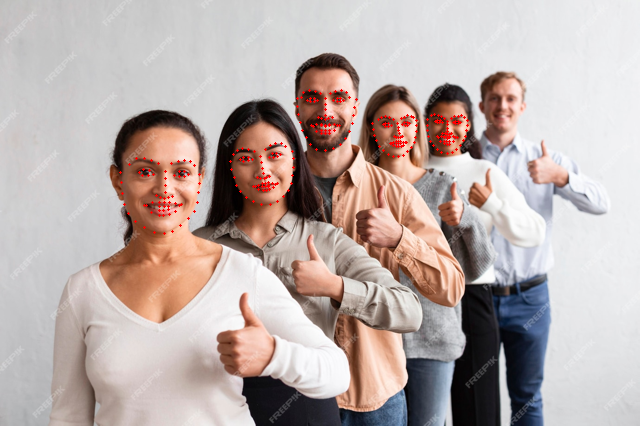

In [3]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource(width=640);
facedect = FaceDetection();
salida   = ml.blocks.Display();
drain    = ml.blocks.Drain();

imagen  ("image"    ) >> facedect("image" );
facedect("image"    ) >> salida  ("image" );
facedect("landmarks") >> drain   ("drain");

source="https://img.freepik.com/foto-gratis/gente-sonriente-dando-pulgar-arriba-sesion-terapia-grupo_23-2148752043.jpg?w=1380&t=st=1704574289~exp=1704574889~hmac=0766e97be83b295a06f324f29f18cbd1f8e59207dd440a2798818f46e548b50e"
context.emit(target=imagen,  sname="source", data=source);
context.wait();


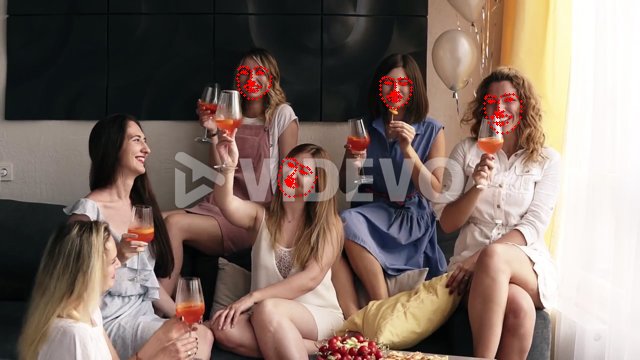

In [4]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context  = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource(width=640, speed=1);
facedct  = FaceDetection();
salida   = ml.blocks.Display();
facedect = FaceDetection();

vídeo   ("frame"    ) >> facedect("image" );
facedect("image"    ) >> salida  ("image" );
facedect("landmarks") >> drain   ("drain");


source="https://v4.cdnpk.net/videvo_files/video/free/video0457/large_watermarked/_import_60bf208e17ef48.95247691_FPpreview.mp4"
context.emit(target=vídeo,  sname="source", data=source);
context.wait();


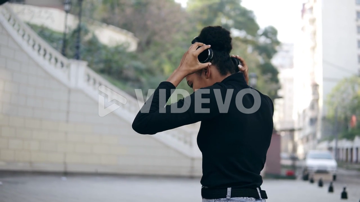

In [5]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource(speed=0.5);
pantalla = ml.blocks.Display(width=360);

vídeo("frame") >> pantalla("image");

context.emit(target=vídeo, sname="source", data="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc3022971d79.05815712_FPpreview.mp4");
context.wait(boredtime=1);


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


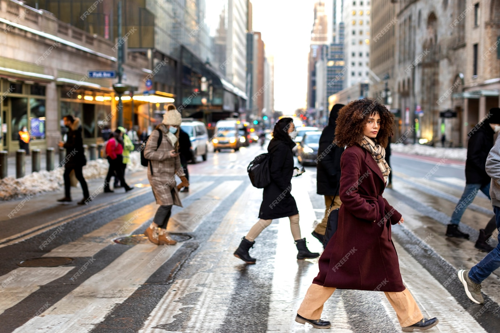

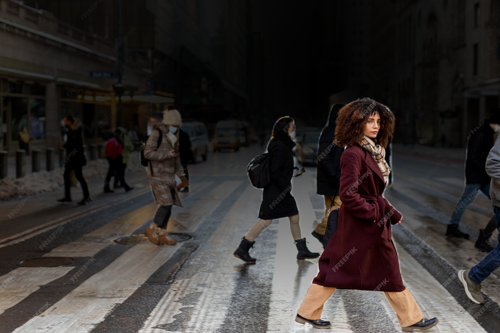

In [6]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
split    = ml.blocks.SplitChannels();
merge    = ml.blocks.MergeChannels();
depth    = ml.blocks.DepthEstimation();
opsR     = ml.blocks.ImageOp(op="eval", expression="convert((float(r)/255)*l,'L')");
opsG     = ml.blocks.ImageOp(op="eval", expression="convert((float(r)/255)*l,'L')");
opsB     = ml.blocks.ImageOp(op="eval", expression="convert((float(r)/255)*l,'L')");
salida   = ml.blocks.Display(width=500, feed=True);

imagen("image") >> split ("image");
imagen("image") >> depth ("image");
imagen("image") >> salida("image");

depth ("image") >> opsR ("left");
depth ("image") >> opsG ("left");
depth ("image") >> opsB ("left");

split("red"   ) >> opsR ("right")
split("green" ) >> opsG ("right")
split("blue"  ) >> opsB ("right")

opsR ("image" ) >> merge("red"  )
opsG ("image" ) >> merge("green")
opsB ("image" ) >> merge("blue" )

merge("image") >> salida("image");

#source="https://img.freepik.com/foto-gratis/mujer-tiro-completo-bicicleta-al-aire-libre_23-2149413735.jpg?w=1380&t=st=1704297833~exp=1704298433~hmac=433c68f72fc841cbb094d598521f8b72dad100a383f59b39de5f490cce7c7b99";
source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen, sname="source", data=source, mods={"sync":True});
context.wait();



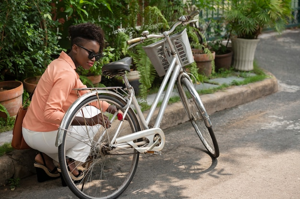

In [7]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
img2text = ml.blocks.ImageToText(caption="A photo of an");
terminal = ml.blocks.Terminal();
salida   = ml.blocks.Display(width=300);

imagen  ("image") >> img2text("image" );
imagen  ("image") >> salida  ("image" );
img2text("text" ) >> terminal("stdout");

source="https://img.freepik.com/foto-gratis/mujer-tiro-completo-bicicleta-al-aire-libre_23-2149413735.jpg";
#source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen, sname="source", data=source);
context.wait(boredtime=1);


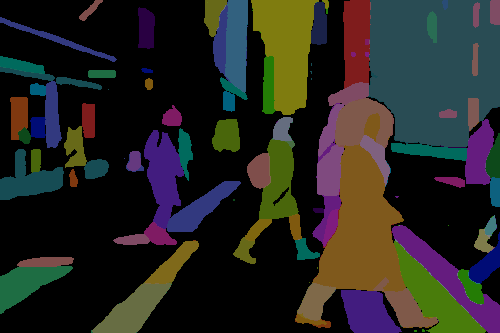

In [ ]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource(width=500);
imgseg   = ml.blocks.SegmentAll(model_name="s");
salida   = ml.blocks.Display();

imagen("image") >> imgseg("image");
imgseg("mask" ) >> salida("image");

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen, sname="source", data=source);
context.wait();


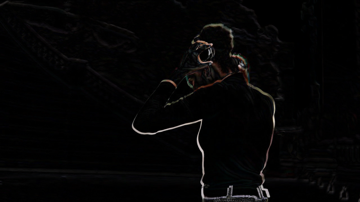

In [ ]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
op       = ml.blocks.ImageOp(op="diff seq");
salida   = ml.blocks.Display(feed=False, width=360, sped=0.5);
#
vídeo ("frame") >> op    ("image");
op    ("image") >> salida("image");

#source="https://v4.cdnpk.net/videvo_files/video/free/video0482/large_watermarked/_import_62bbefe51f3547.77164811_FPpreview.mp4";
source="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc3022971d79.05815712_FPpreview.mp4";

context.emit(target=vídeo, sname="source", data=source);
context.wait(boredtime=1);


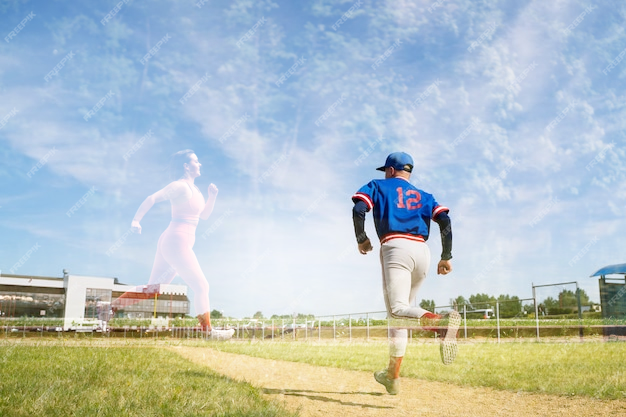

In [ ]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

image_left  = ml.blocks.ImageSource();
image_right = ml.blocks.ImageSource();
op          = ml.blocks.ImageOp(op="screen");
salida      = ml.blocks.Display();

image_left ("image") >> op    ("left" );
image_right("image") >> op    ("right");
op         ("image") >> salida("image");

source_left  = "https://img.freepik.com/foto-gratis/mujer-tiro-completo-corriendo-al-aire-libre_23-2149622958.jpg?w=1380&t=st=1704273288~exp=1704273888~hmac=7b34946ecff9d06c9fef1f159d2bdb54361e355eb7c34648b1b153b0cb4a84f7";
source_right = "https://img.freepik.com/foto-gratis/nino-vista-lateral-corriendo-campo_23-2149457304.jpg?t=st=1704273288~exp=1704273888~hmac=7e375feb2153c63c38aed1e5a4bd467c2210a61c6500f14e806299094f57e0dc";

context.emit(target=image_left,  sname="source", data=source_left);
context.emit(target=image_right, sname="source", data=source_right);
context.wait(boredtime=1);



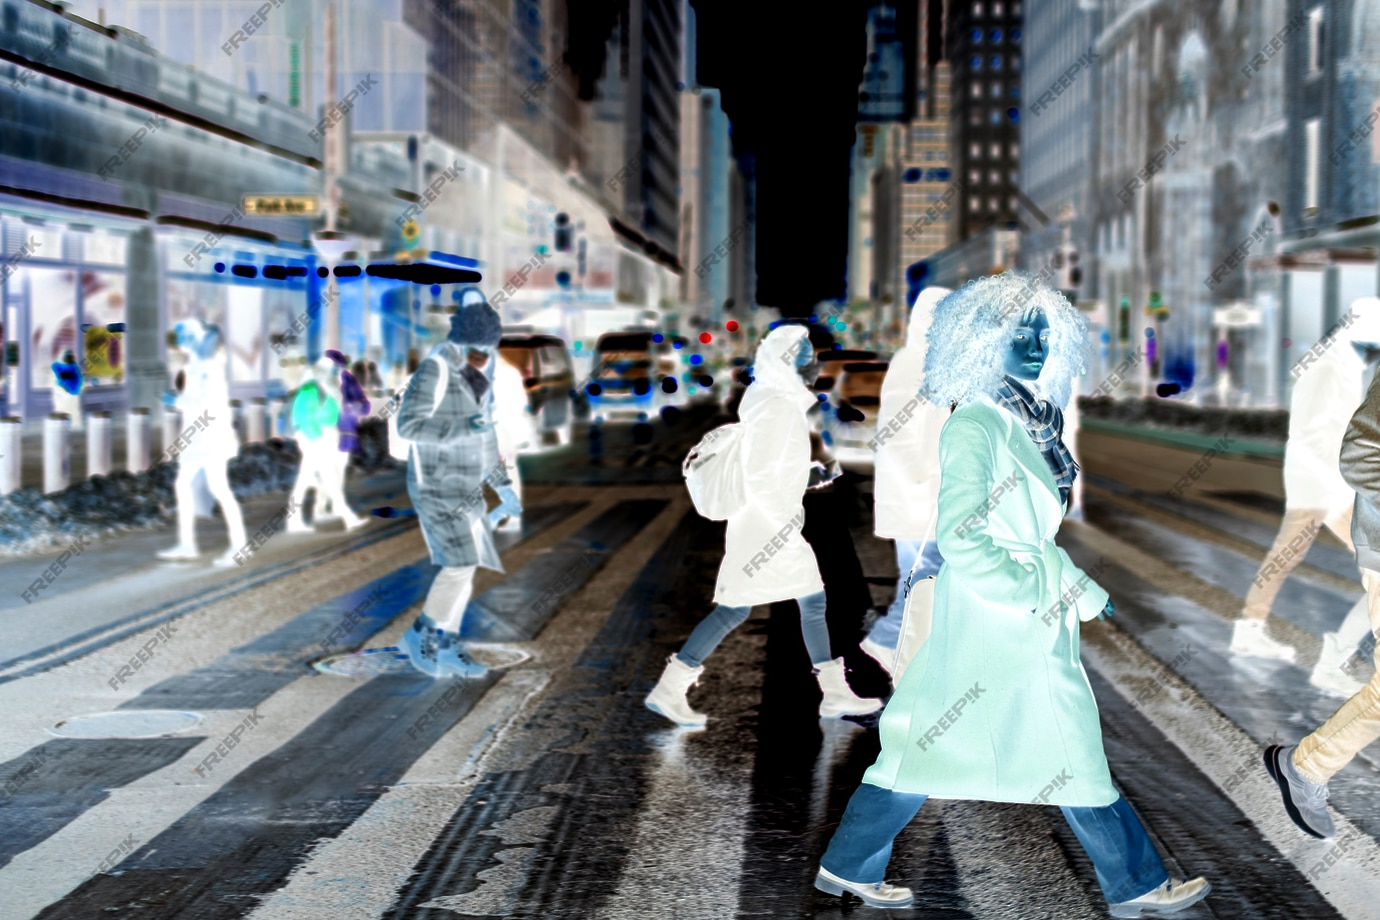

In [ ]:
from ml4teens.tools import debug;
debug.disable();

import sys, traceback;

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
op       = ml.blocks.ImageOp(op="invert");
salida   = ml.blocks.Display();

imagen("image") >> op    ("image");
op    ("image") >> salida("image");

source = "https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen,  sname="source", data=source);
context.wait(boredtime=1);


/home/fran/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


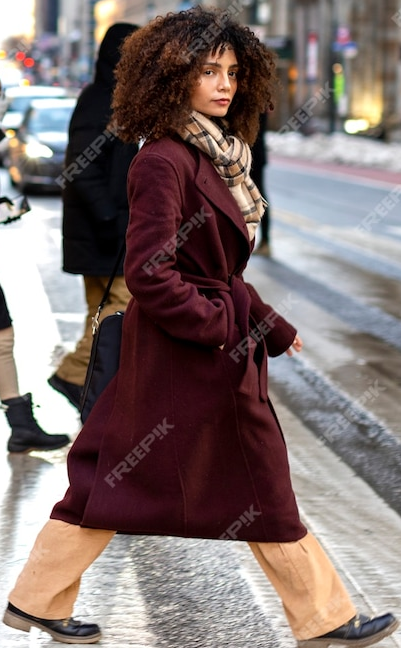

In [1]:
"""
==============================
Falla, con n=2 sólo muestra 1.
==============================
"""

from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context = ml.core.Context.instance;
context.reset();
context.sync=False;

imagen   = ml.blocks.ImageSource();
objid    = ml.blocks.ObjectID(model_name="l", n=2);
cropi    = ml.blocks.CropImage(); #conf=0.85, classes=[0]);
salida   = ml.blocks.Display(feed=True);

imagen("image") >> objid ("image");
imagen("image") >> cropi ("image");
objid ("boxes") >> cropi ("boxes");
cropi ("image") >> salida("image");

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307"

context.emit(target=imagen,  sname="source", data=source);
context.wait(boredtime=1);


/home/fran/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Ejecutando el slot 'source' de ml4teens.blocks.videoSource:VideoSource, con data=<class 'str'> y mods='{}'


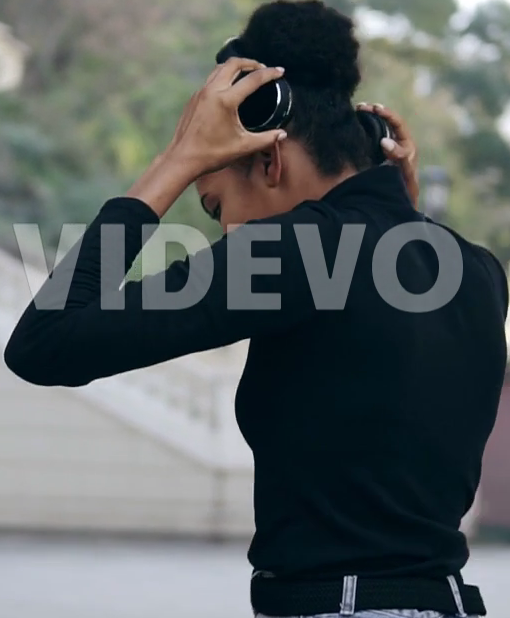

In [1]:
"""
No sincroniza!
"""

import ml4teens as ml;

context = ml.core.Context.instance.reset();
context.sync=True;

vídeo    = ml.blocks.VideoSource(speed=0.5);
objid    = ml.blocks.ObjectID(model_name="xs");
cropi    = ml.blocks.CropImage(n=1);
salida   = ml.blocks.Display(feed=False);

vídeo ("frame") >> objid ("image");
vídeo ("frame") >> cropi ("image");
objid ("boxes") >> cropi ("boxes");
cropi ("image") >> salida("image");

#source="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc2f69bd3275.18895086_FPpreview.mp4";
source="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc3022971d79.05815712_FPpreview.mp4";

context.emit(target=vídeo, sname="source", data=source);
context.wait(boredtime=1);


## Vídeo al que se le ajusta el tamaño según el tamaño de una imagen exterior.

La siguiente celda muestra cómo podemos tener más de un punto de inicio.

**Observar**: se ejecutan (context.run) varios bloques, primero 'imagen' (que establece el shape que ha de tener el vídeo) y luego 'vídeo'.

Mandando a ml4teens.blocks.videoSource:VideoSource una señal al slot 'source' con data=<class 'str'> y mods='{}'
Mandando a ml4teens.blocks.imageSource:ImageSource una señal al slot 'source' con data=<class 'str'> y mods='{}'


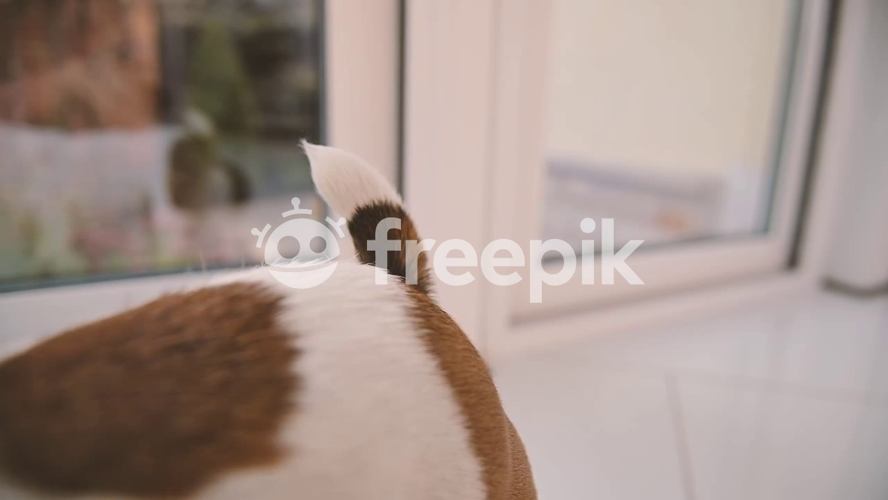

In [2]:
"""
No funciona!
La imagen de vídeo no se reduce si sync=True
Si context.sync=False, a veces redimensikona otras no.
"""

from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;
context.sync=False;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource(height=175);
vídeo    = ml.blocks.VideoSource(speed=0.5);
resize   = ml.blocks.ResizeImage(height=500);
salida   = ml.blocks.Display(feed=False);

imagen("image") >> resize("shape","keep");
vídeo ("frame") >> resize("image");
resize("image") >> salida("image");

source_imagen = "https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";
source_vídeo  = "https://v5.cdnpk.net/videvo_files/video/premium/partners0817/large_watermarked/h8caae9f6_V0027_049_B_FPpreview.mp4";

context.emit(target=vídeo,  sname="source", data=source_vídeo);
context.emit(target=imagen, sname="source", data=source_imagen);
context.wait();



Mandando a ml4teens.blocks.videoSource:VideoSource una señal al slot 'source' con data=<class 'str'> y mods='{}'


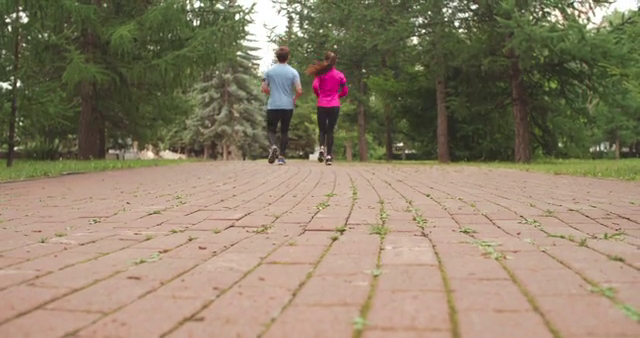

In [3]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource(width=640);
resize   = ml.blocks.ResizeImage();
salida   = ml.blocks.Display();

vídeo ("frame") >> resize("image");
resize("image") >> salida("image");

source="https://player.vimeo.com/external/371564393.sd.mp4?s=33b5f1326e4b6dbad0b65ef289fd08ee3835ecbc&profile_id=164&oauth2_token_id=57447761";

context.emit(target=vídeo,  sname="source", data=source);
context.wait();


Mandando a ml4teens.blocks.imageSource:ImageSource una señal al slot 'source' con data=<class 'str'> y mods='{}'


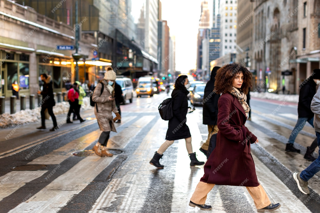

In [4]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();
context.sync=False;

imagen   = ml.blocks.ImageSource();
split    = ml.blocks.SplitChannels();
merge    = ml.blocks.MergeChannels();
salida   = ml.blocks.Display(width=320, feed=True);

imagen("image") >> split ("image");
split ("red"  ) >> merge ("red"  );
split ("green") >> merge ("green");
split ("blue" ) >> merge ("blue" );
merge ("image") >> salida("image");

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307"

context.emit(target=imagen,  sname="source", data=source);
context.wait();


Mandando a ml4teens.blocks.imageSource:ImageSource una señal al slot 'source' con data=<class 'str'> y mods='{}'


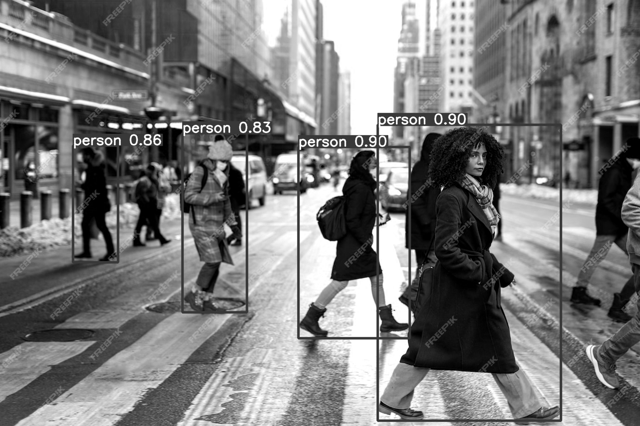

In [5]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
objid    = ml.blocks.ObjectID(model_name="xs", conf=0.80);
grey     = ml.blocks.SingleChannel(channel=2);
salida   = ml.blocks.Display(width=640);
terminal = ml.blocks.Terminal();

((imagen("image") >> objid("image"))("image") >> grey("image"))("image")>> salida("image");

#objid("boxes") >> terminal("stdout");

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen,  sname="source", data=source);
context.wait();



Mandando a ml4teens.blocks.videoSource:VideoSource una señal al slot 'source' con data=<class 'str'> y mods='{}'


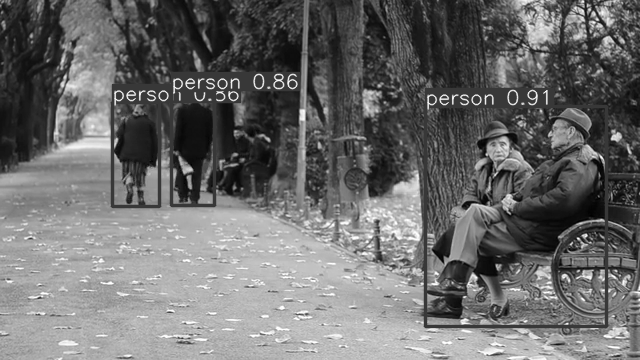

In [7]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
grey     = ml.blocks.SingleChannel(channel=1);
objid    = ml.blocks.ObjectID(model_name="xs", conf=0.60);
salida   = ml.blocks.Display(width=640);

((vídeo("frame") >> objid("image"))("image") >> grey("image"))("image") >> salida("image");

source="https://cdn.pixabay.com/vimeo/188704568/parque-6096.mp4?width=640&hash=112e5fd94cb9090c07f4472a41d182d344db647b";

context.emit(target=vídeo,  sname="source", data=source);
context.wait();


Mandando a ml4teens.blocks.videoSource:VideoSource una señal al slot 'source' con data=<class 'str'> y mods='{}'


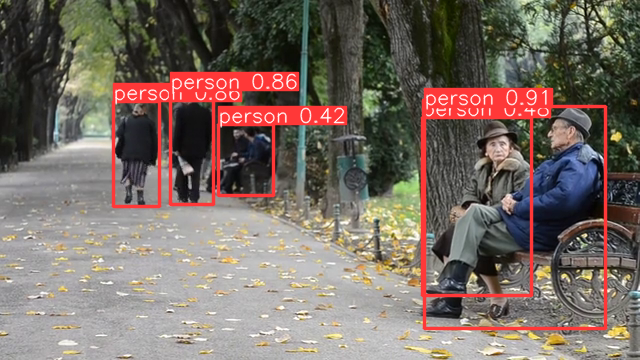

In [8]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
objid    = ml.blocks.ObjectID(model_name="xs");
salida   = ml.blocks.Display(width=640);

vídeo("frame") >> objid("image");
objid("image") >> salida("image");

source="https://cdn.pixabay.com/vimeo/188704568/parque-6096.mp4?width=640&hash=112e5fd94cb9090c07f4472a41d182d344db647b"

context.emit(target=vídeo,  sname="source", data=source);
context.wait();
